In [ ]:
!nvidia-smi

In [ ]:
!pip install gdown
#!pip install tensorflow-gpu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

In [2]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [3]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


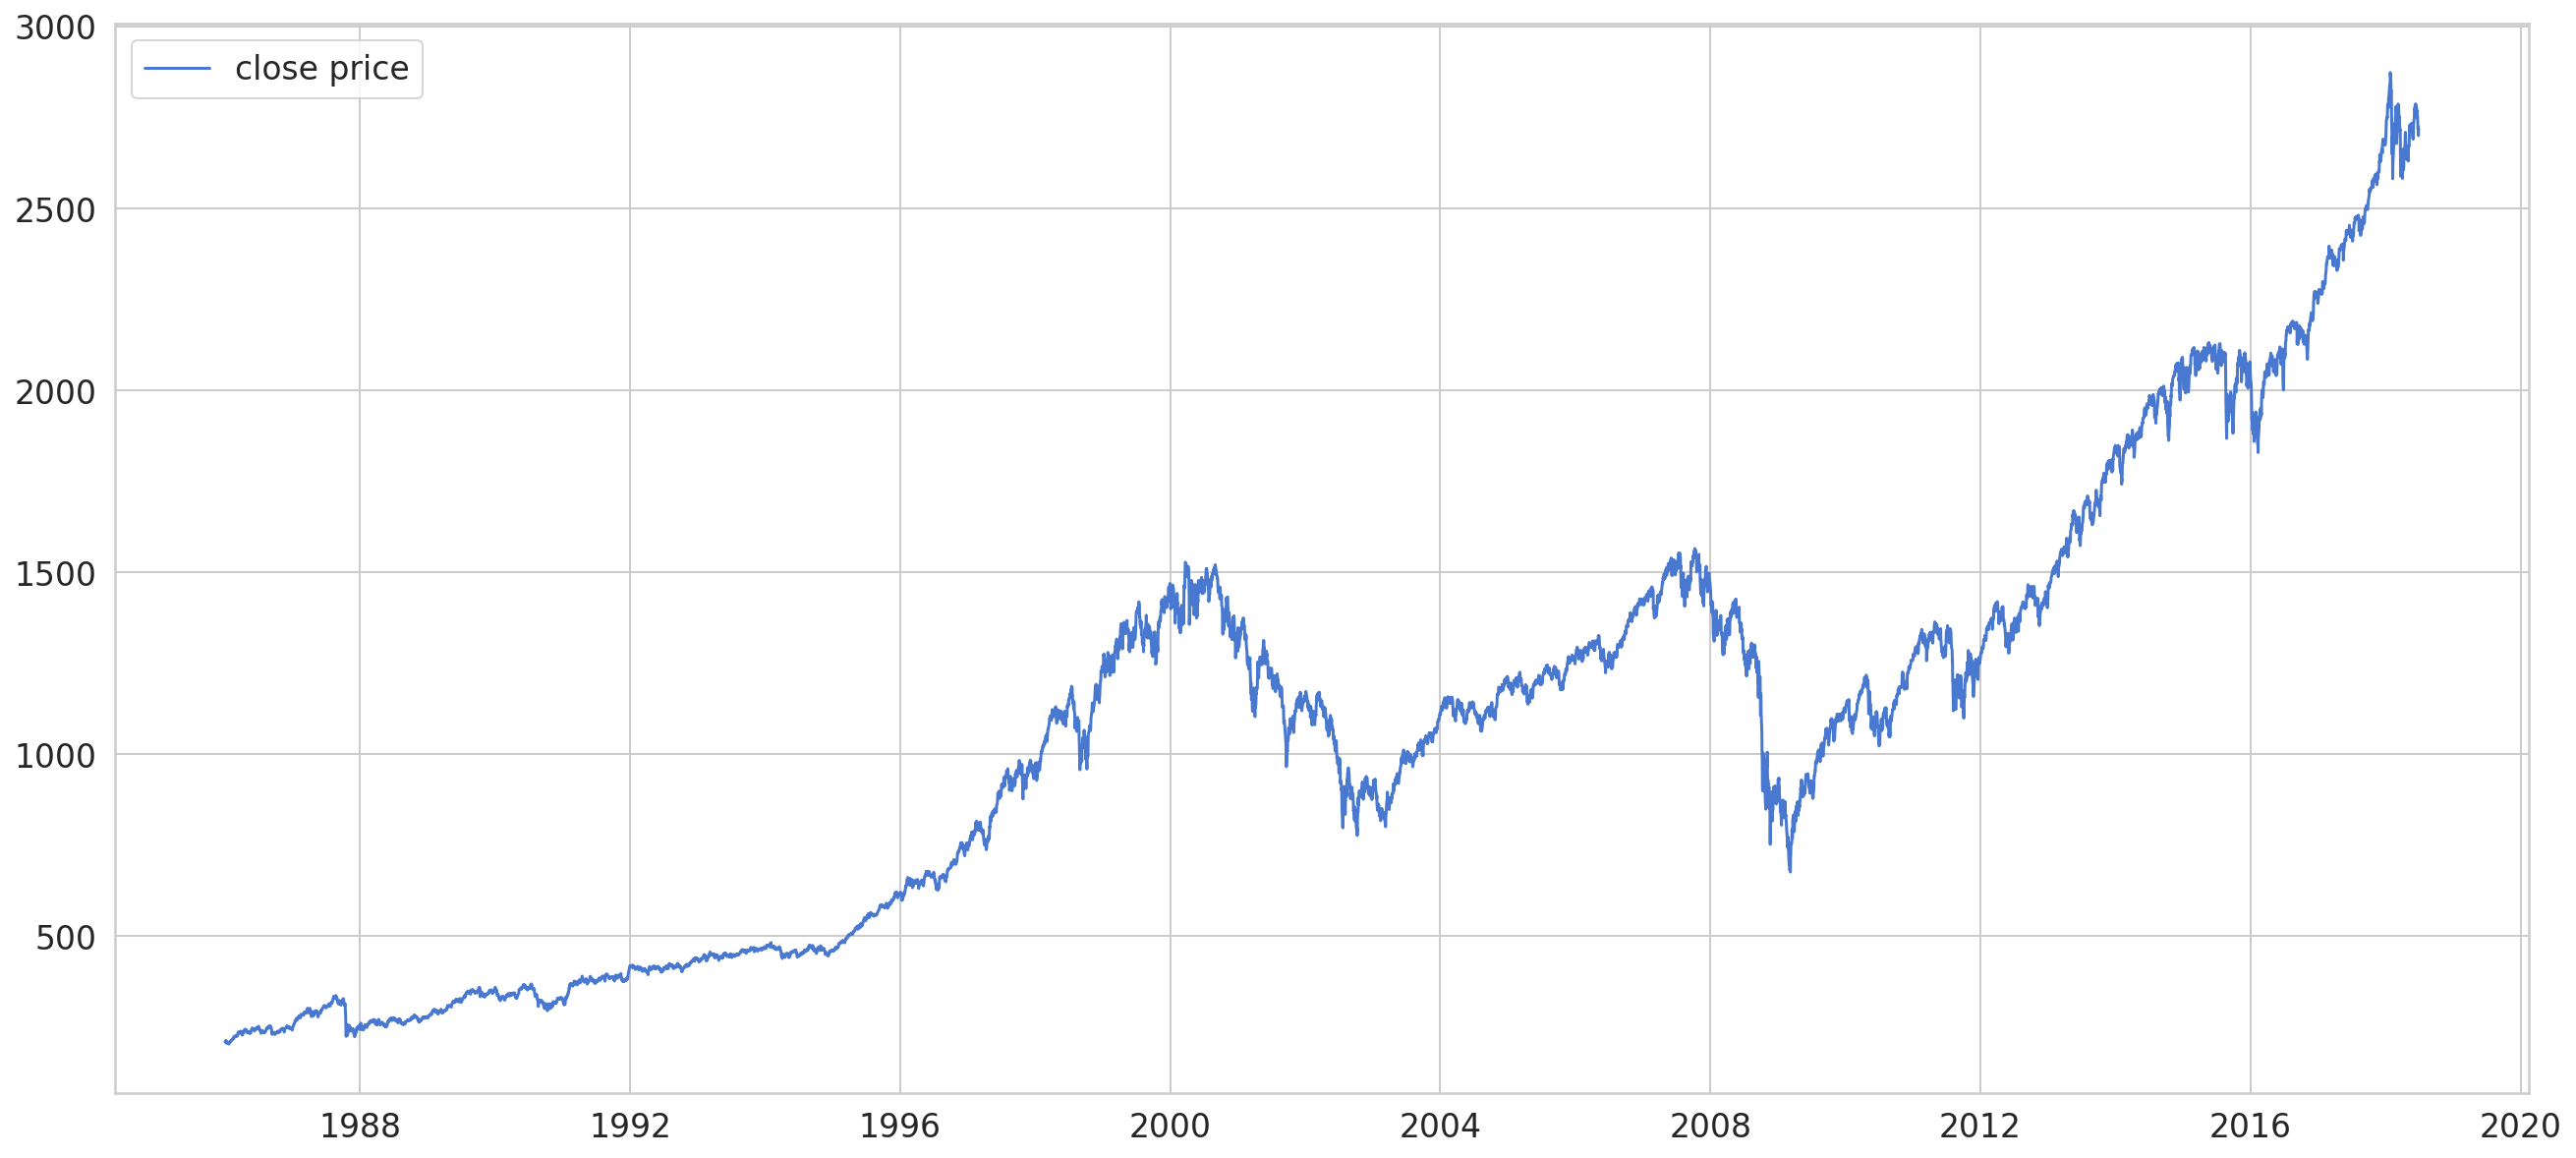

In [4]:
plt.plot(df, label='close price')
plt.legend();

In [5]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/home/sbergste/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sbergste/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
train

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169
...,...
2016-11-04,2.047774
2016-11-07,2.134814
2016-11-08,2.149916


In [9]:
train[['close']]

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169
...,...
2016-11-04,2.047774
2016-11-07,2.134814
2016-11-08,2.149916


In [10]:
train.close

date
1986-01-02   -1.475126
1986-01-03   -1.472703
1986-01-06   -1.473135
1986-01-07   -1.467219
1986-01-08   -1.478169
                ...   
2016-11-04    2.047774
2016-11-07    2.134814
2016-11-08    2.149916
2016-11-09    2.194431
2016-11-10    2.202357
Name: close, Length: 7782, dtype: float64

In [11]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [12]:
X_train

array([[[-1.4751264 ],
        [-1.47270341],
        [-1.47313541],
        ...,
        [-1.46263578],
        [-1.46323683],
        [-1.46314291]],

       [[-1.47270341],
        [-1.47313541],
        [-1.4672188 ],
        ...,
        [-1.46323683],
        [-1.46314291],
        [-1.46045696]],

       [[-1.47313541],
        [-1.4672188 ],
        [-1.47816923],
        ...,
        [-1.46314291],
        [-1.46045696],
        [-1.4560242 ]],

       ...,

       [[ 2.18817637],
        [ 2.209664  ],
        [ 2.17164742],
        ...,
        [ 2.05431069],
        [ 2.04777424],
        [ 2.13481417]],

       [[ 2.209664  ],
        [ 2.17164742],
        [ 2.2038413 ],
        ...,
        [ 2.04777424],
        [ 2.13481417],
        [ 2.14991562]],

       [[ 2.17164742],
        [ 2.2038413 ],
        [ 2.1905618 ],
        ...,
        [ 2.13481417],
        [ 2.14991562],
        [ 2.19443107]]])

In [13]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 4s 19ms/step - loss: 0.1691 - val_loss: 0.1827
Epoch 2/10
218/218 [==============================] - 3s 16ms/step - loss: 0.0934 - val_loss: 0.1589
Epoch 3/10
218/218 [==============================] - 3s 16ms/step - loss: 0.0964 - val_loss: 0.1302
Epoch 4/10
218/218 [==============================] - 4s 19ms/step - loss: 0.0879 - val_loss: 0.1045
Epoch 5/10
218/218 [==============================] - 4s 18ms/step - loss: 0.0919 - val_loss: 0.0656
Epoch 6/10
218/218 [==============================] - 4s 18ms/step - loss: 0.1048 - val_loss: 0.1019
Epoch 7/10
218/218 [==============================] - 4s 18ms/step - loss: 0.1007 - val_loss: 0.0745
Epoch 8/10
218/218 [==============================] - 4s 18ms/step - loss: 0.1090 - val_loss: 0.0639
Epoch 9/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1035 - val_loss: 0.1178
Epoch 10/10
218/218 [==============================] - 4s 19ms/step - loss: 0.1131 - val_lo

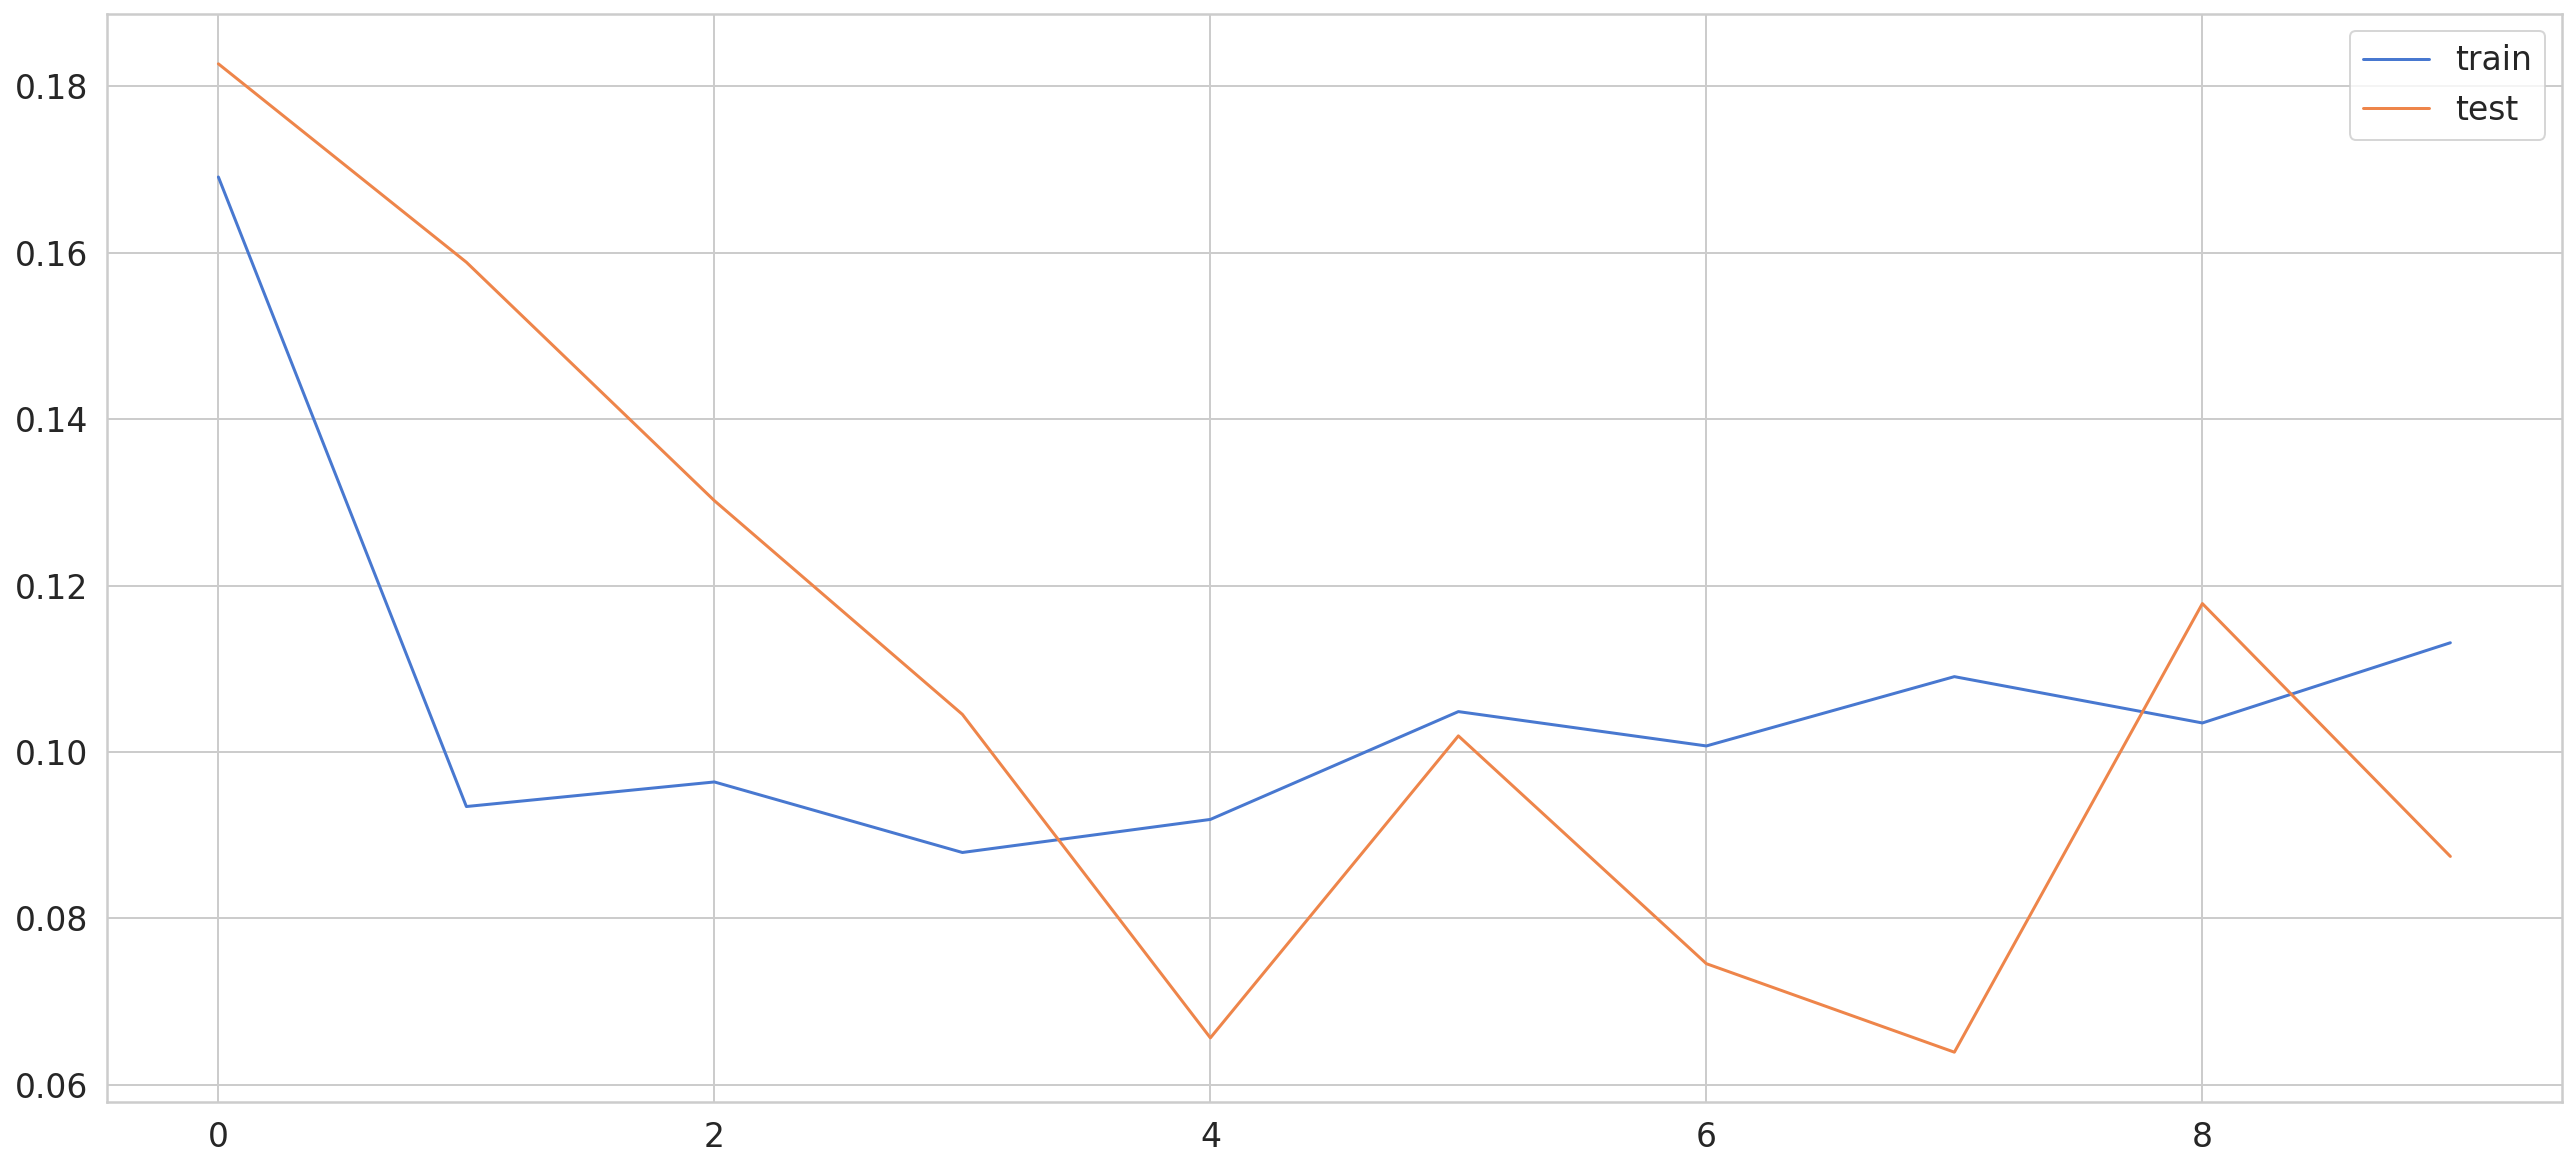

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [16]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [17]:
X_train.shape

(7752, 30, 1)

In [18]:
X_train_pred.shape

(7752, 30, 1)

In [19]:
print(X_train[0, 29, 0])

-1.463142913948354


In [20]:
X_train[0]

array([[-1.4751264 ],
       [-1.47270341],
       [-1.47313541],
       [-1.4672188 ],
       [-1.47816923],
       [-1.48166285],
       [-1.48194459],
       [-1.48051709],
       [-1.48066735],
       [-1.47762452],
       [-1.47591528],
       [-1.47730522],
       [-1.47899568],
       [-1.4822639 ],
       [-1.48658396],
       [-1.48515646],
       [-1.48106179],
       [-1.47925864],
       [-1.47471318],
       [-1.4738116 ],
       [-1.47561475],
       [-1.47101295],
       [-1.46691828],
       [-1.46911587],
       [-1.46879656],
       [-1.46783864],
       [-1.4657913 ],
       [-1.46263578],
       [-1.46323683],
       [-1.46314291]])

In [21]:
X_train_pred[0]

array([[-0.78163844],
       [-0.6714233 ],
       [-0.71921813],
       [-0.7117779 ],
       [-0.7138974 ],
       [-0.7137409 ],
       [-0.71403253],
       [-0.7142236 ],
       [-0.7143862 ],
       [-0.7145003 ],
       [-0.71457714],
       [-0.7146263 ],
       [-0.7146567 ],
       [-0.7146751 ],
       [-0.71468604],
       [-0.7146925 ],
       [-0.71469617],
       [-0.7146983 ],
       [-0.71469945],
       [-0.7147001 ],
       [-0.7147005 ],
       [-0.7147007 ],
       [-0.7147008 ],
       [-0.7147009 ],
       [-0.71470094],
       [-0.71470094],
       [-0.71470094],
       [-0.71470094],
       [-0.71470094],
       [-0.7147008 ]], dtype=float32)

In [22]:
np.mean(np.abs(X_train_pred[0] - X_train[0]))

0.7591794726442609

In [23]:
X = np.asarray([X_train[0]])

In [24]:
X

array([[[-1.4751264 ],
        [-1.47270341],
        [-1.47313541],
        [-1.4672188 ],
        [-1.47816923],
        [-1.48166285],
        [-1.48194459],
        [-1.48051709],
        [-1.48066735],
        [-1.47762452],
        [-1.47591528],
        [-1.47730522],
        [-1.47899568],
        [-1.4822639 ],
        [-1.48658396],
        [-1.48515646],
        [-1.48106179],
        [-1.47925864],
        [-1.47471318],
        [-1.4738116 ],
        [-1.47561475],
        [-1.47101295],
        [-1.46691828],
        [-1.46911587],
        [-1.46879656],
        [-1.46783864],
        [-1.4657913 ],
        [-1.46263578],
        [-1.46323683],
        [-1.46314291]]])

In [25]:
t = model.predict(X)

In [26]:
t

array([[[-0.78163844],
        [-0.6714233 ],
        [-0.71921813],
        [-0.711778  ],
        [-0.71389735],
        [-0.7137409 ],
        [-0.71403253],
        [-0.7142236 ],
        [-0.7143862 ],
        [-0.7145003 ],
        [-0.7145771 ],
        [-0.7146263 ],
        [-0.7146567 ],
        [-0.71467507],
        [-0.71468604],
        [-0.7146925 ],
        [-0.71469617],
        [-0.7146983 ],
        [-0.71469945],
        [-0.7147001 ],
        [-0.71470046],
        [-0.71470076],
        [-0.71470076],
        [-0.7147008 ],
        [-0.71470094],
        [-0.7147008 ],
        [-0.71470094],
        [-0.7147009 ],
        [-0.71470094],
        [-0.7147008 ]]], dtype=float32)

In [27]:
train_mae_loss

array([[0.75917947],
       [0.75896814],
       [0.75894685],
       ...,
       [0.14726796],
       [0.12193358],
       [0.09168729]])

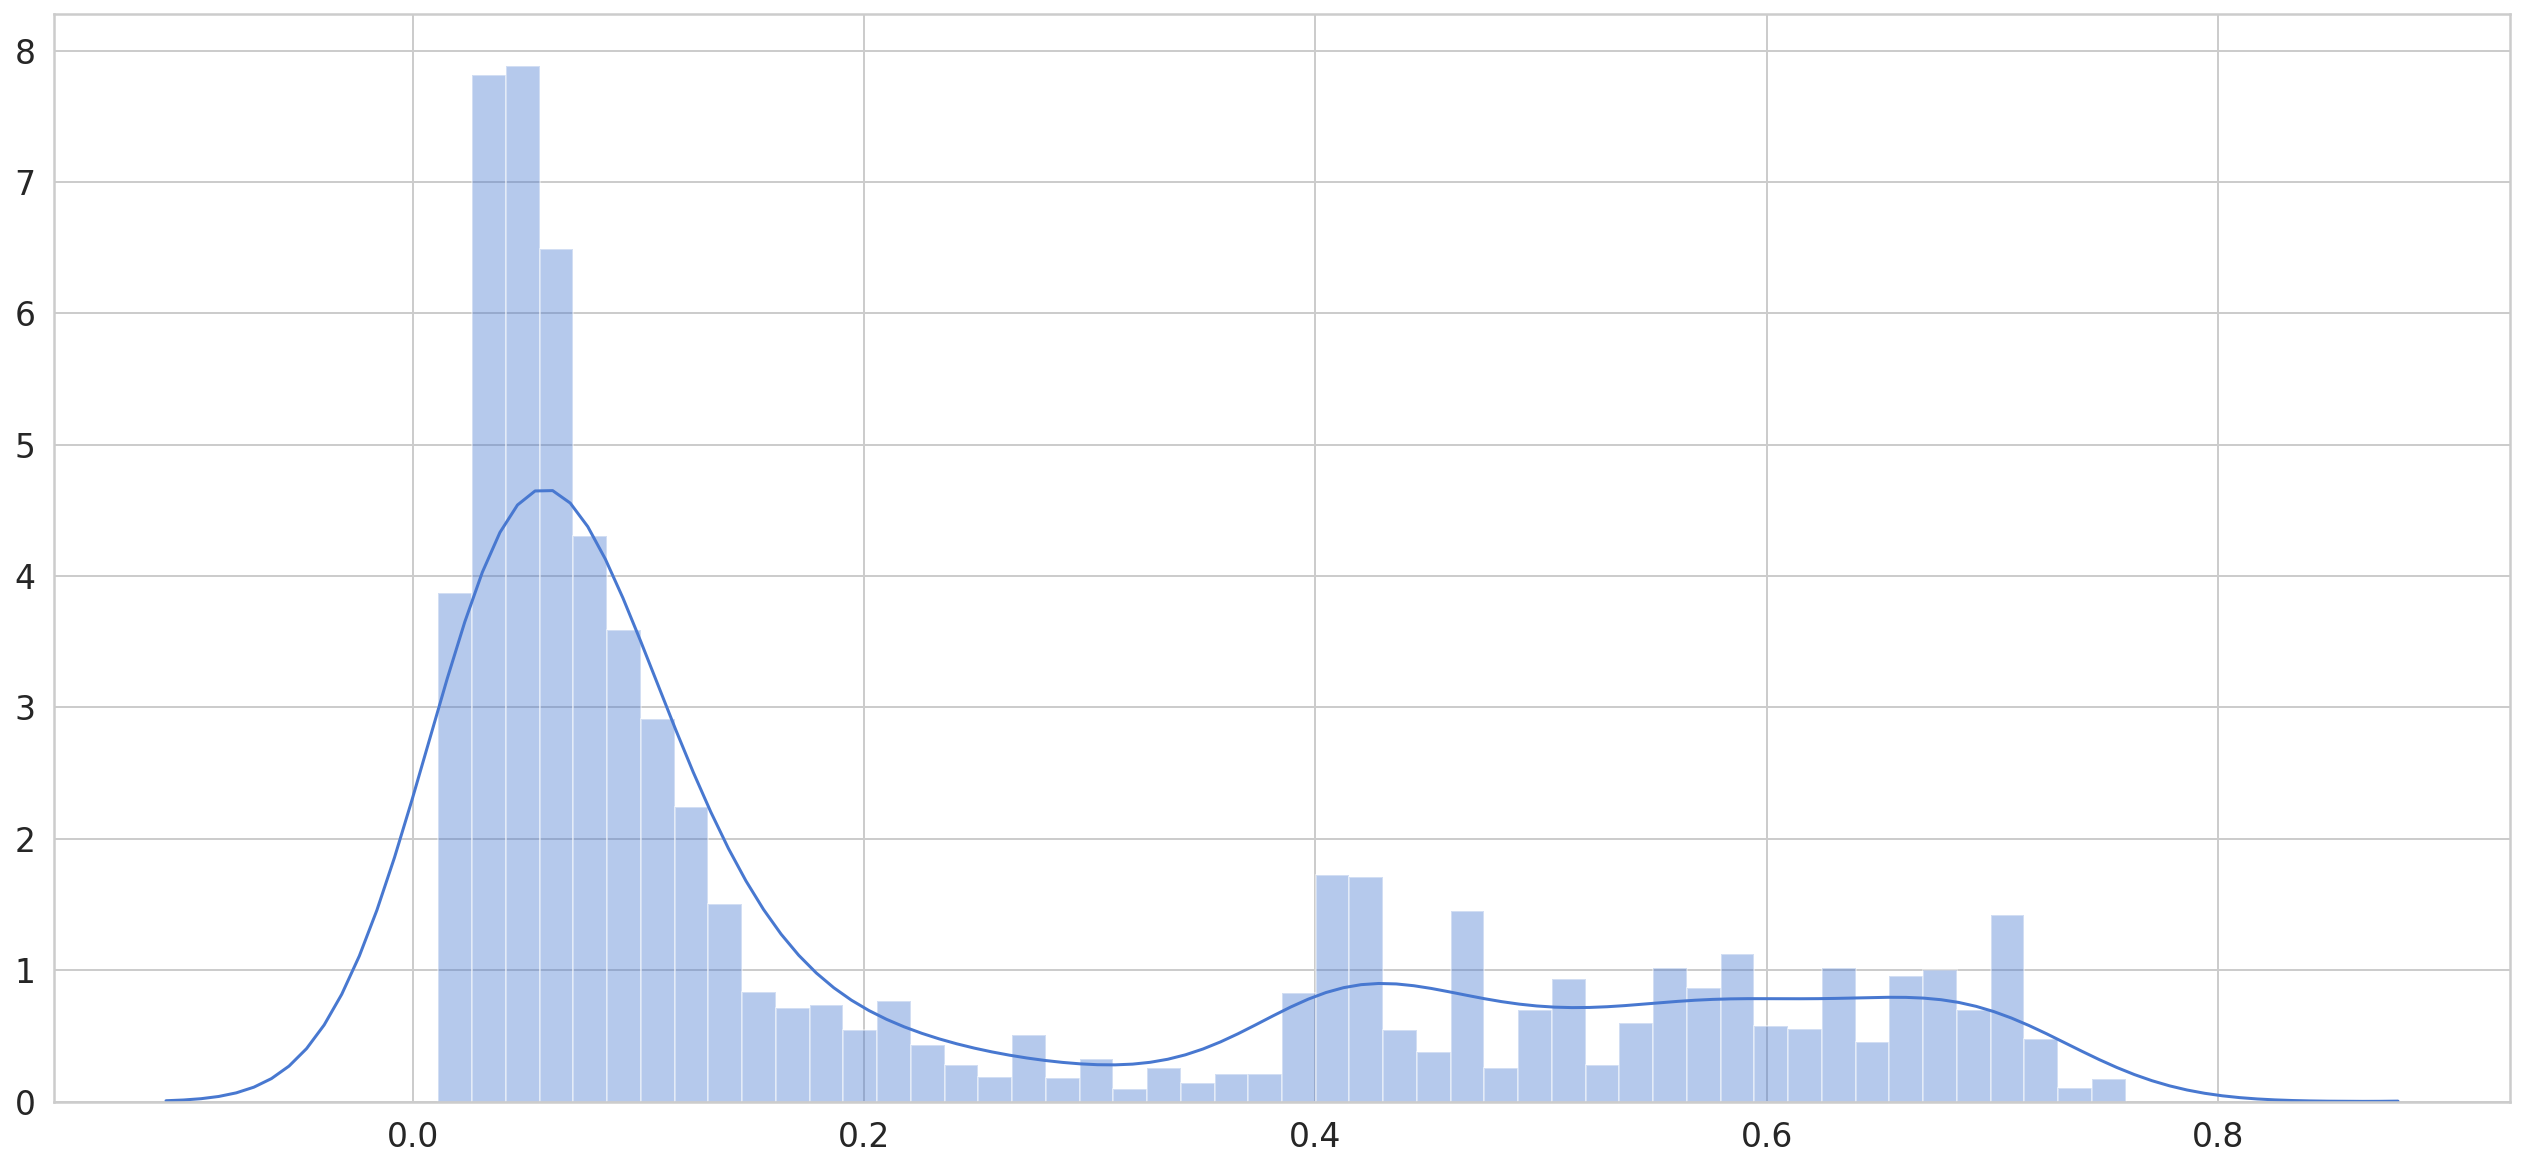

In [28]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [29]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:
THRESHOLD = 0.5

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

In [ ]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();